In [1]:
"""
    Comparing colormaps of the data and BBarolo model.

"""
import os
import pickle
import numpy as np
from numpy import ma

from astropy.wcs import WCS
from astropy.io import fits
from scipy.integrate import cumtrapz

from dictionaryThings import loadDict
from ObsInfo import ObsInfo
from pixelThings import findValidPixels, pixMinMax
from maskThings import maskTrue,maskFalse
from fitsThings import buildWcs
from fluxThings import calcGaussFluxes, calcTotIntFluxes
from plotBbaroloMapsThings import plotLineProfiles, makeColormaps
from velocityThings import calcVel

The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
out = 'modOut2'
arcsec = '1arc'
topDir = '/Volumes/QbertPrimary/umdResearch/adapProposalNearby/'


# ----------------------------------------- #
# Necessary parameter file and dictionaries #
# ----------------------------------------- #
# Dictionary of galaxy properties
objDictName = topDir + 'objectInfoDict.pkl'
# Dictionary of emission line properties.
lineDict = loadDict(topDir + 'emiLineDict.pkl')
# Text file of line fitting parameters.
paramFileName = topDir + 'fittingParametersV4.txt'


# -------------------------------------------------- #
# Read in the parameter file containing line profile #
# velocity limits and continuum fitting information. #
# -------------------------------------------------- #
paramFileData = np.genfromtxt(paramFileName, dtype = None, 
                              autostrip = True, names = True, encoding=None)


for x in range(len(paramFileData)):
    # ------------------------------------ #
    # Get the galaxy and line information. #
    # ------------------------------------ #
    obsInfo = ObsInfo(x, paramFileName, objDictName)
    
    # Name of the emission line.
    lineName = paramFileData['lineNameShort'][x]
    # Rest wavelength of the emission line.
    restWave = lineDict[lineName]['restWave']


    # ----------------------------------------- #
    # Create the base names for saving outputs. #
    # ----------------------------------------- #
    # Base for the object's file names.
    objectNameBase = (str(obsInfo.obsId)+'_'+obsInfo.objectName
                      +'_'+lineName)
    
    # Base path to the object's folders.
    objectPathBase = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName
                          +'/'+arcsec+'/3dBarolo/')
    if (not os.path.exists(objectPathBase)):os.makedirs(objectPathBase)


    fitsFile = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                +arcsec+'/outFitsFiles2/'+objectNameBase+'.fits')
    fitsHdu = fits.open(fitsFile)
    vels = fitsHdu['zCorrVels'].data
    data = fitsHdu['contSubFluxes'].data
    trueMask = np.ma.getmask(np.ma.masked_where(data==0,data)) 
    dataMasked = np.ma.masked_array(fitsHdu['contSubFluxes'].data,mask=trueMask)
    dataModMasked = np.ma.masked_array(fitsHdu['modelFluxes'].data,mask=trueMask)
    dataFluxesMasked = np.ma.masked_array(fitsHdu['flux'].data,mask=trueMask[100,:,:])
    dataV50Masked = np.ma.masked_array(fitsHdu['v50'].data,mask=trueMask[100,:,:])
    dataW1Masked = np.ma.masked_array(fitsHdu['w1'].data,mask=trueMask[100,:,:])

    pacsWcs=WCS(fitsHdu['image'].header).celestial
    nRows,nCols,nFluxes = data.shape[2], data.shape[1], data.shape[0]
    minProfIdx = (np.abs(vels - (obsInfo.profileMin))).argmin()
    maxProfIdx = (np.abs(vels - (obsInfo.profileMax))).argmin()
    
    print obsInfo.objectName, lineName
    break

circinus oiii88


In [4]:
    # Make an array of coordinates for the valid spaxels
    validPixels = findValidPixels((nCols,nRows),trueMask[100,:,:])
    wcsMinMax = pixMinMax(validPixels)

In [5]:
    barFile = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
               +arcsec+'/barModFitting/outFitsFiles/'+objectNameBase+'.fits')
    barHdu = fits.open(barFile)
    barIntFluxes = np.ma.masked_array(barHdu['flux'].data,mask=trueMask[100,:,:])
    barModelFluxes = np.ma.masked_array(barHdu['modelFluxes'].data,mask=trueMask)
    barV50 = np.ma.masked_array(barHdu['v50'].data,mask=trueMask[100,:,:])

    barW1Temp = np.ma.masked_array(barHdu['w1'].data,mask=trueMask[100,:,:])
    barW1 = np.ma.masked_where(barW1Temp==0.,barW1Temp)

    imageListFluxFrac = [dataFluxesMasked, barIntFluxes, dataFluxesMasked-barIntFluxes,
                         dataV50Masked,    barV50, dataV50Masked-barV50,
                         dataW1Masked,     barW1, dataW1Masked-barW1]

In [6]:
    try:
        ringLogFile = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                       +arcsec+'/3dBarolo/'+lineName+'/'+out+'/ringlog2.txt')
        rad,vrot,disp,inc,pa,z0,xpos,ypos,vsys,vrad = np.genfromtxt(ringLogFile,skip_header=1,usecols=(1,2,3,4,5,7,9,10,11,12),unpack=True) 

    except:
        ringLogFile = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                       +arcsec+'/3dBarolo/'+lineName+'/'+out+'/ringlog1.txt')
        rad,vrot,disp,inc,pa,z0,xpos,ypos,vsys,vrad = np.genfromtxt(ringLogFile,skip_header=1,usecols=(1,2,3,4,5,7,9,10,11,12),unpack=True) 

    xmin,ymin = 0,0
    xmax,ymax = dataFluxesMasked.shape

    xcen, ycen, phi = [np.nanmean(xpos)-xmin,np.nanmean(ypos)-ymin,np.nanmean(pa)]

    # Coordinates of the major axis.
    x = np.arange(0,xmax-xmin,0.1) 
    y = np.tan(np.radians(phi-90))*(x-xcen)+ycen 

    
    vsys = np.nanmean(vsys)
    pa = np.nanmean(pa)

    radius = np.concatenate((rad,-rad)) 
    vrotation, inclin, vsystem, posang = vrot, inc, vsys, pa  

    vlos1 = vrotation*np.sin(np.deg2rad(inclin))+vsystem 
    vlos2 = vsystem-vrotation*np.sin(np.deg2rad(inclin)) 

    reverse = True 
    if reverse==True: vlos1, vlos2 = vlos2, vlos1 
    vlos = np.concatenate((vlos1,vlos2)) 

In [7]:
    top = topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'+arcsec+'/3dBarolo/'+lineName+'/'+out+'/maps/'+obsInfo.objectName
    mom0 = fits.open(top+'_0mom.fits')[0].data
    mom1 = fits.open(top+'_1mom.fits')[0].data - np.nanmean(vsys)
    mom2 = fits.open(top+'_2mom.fits')[0].data

    mom0Mod = fits.open(top+'_local_0mom.fits')[0].data
    mom1Mod = fits.open(top+'_local_1mom.fits')[0].data - np.nanmean(vsys)
    mom2Mod = fits.open(top+'_local_2mom.fits')[0].data

    imageListMom = [mom0,mom0Mod, mom0-mom0Mod,
                    mom1,mom1Mod, mom1-mom1Mod,
                    mom2,mom2Mod, mom2-mom2Mod]

In [8]:
    #newMask = None
    
    newMask = np.ma.getmask(np.ma.masked_invalid(mom2Mod))
    #newMask = np.ma.getmask(np.ma.masked_where(barW1==0.,barW1))
    #fracMask = np.ma.getmask(np.ma.masked_where(w1==0.,w1))

Unknown coordinate system, RA---TAN, DEC--TAN, equinox=nan


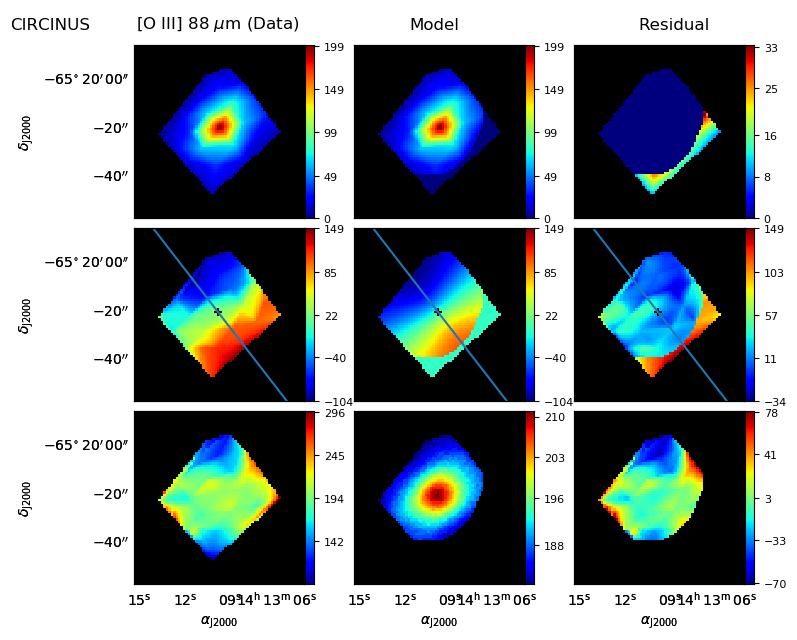

In [9]:
    # Line properties computed via fractional flux.
    saveFile = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                +arcsec+'/3dBarolo/'+lineName+'/'+out+'/'+lineName
                +'_cmapFluxFrac.pdf')

    makeColormaps(images=imageListFluxFrac,
                  wcs=pacsWcs,
                  majX=x,
                  majY=y,
                  xCen=xcen,
                  yCen=ycen,
                  objectName=obsInfo.objectName,
                  lineLabel=lineDict[lineName]['texLabel'],
                  saveFile=saveFile,
                  mask = newMask,
                  savePlot=False)

Unknown coordinate system, RA---TAN, DEC--TAN, equinox=nan


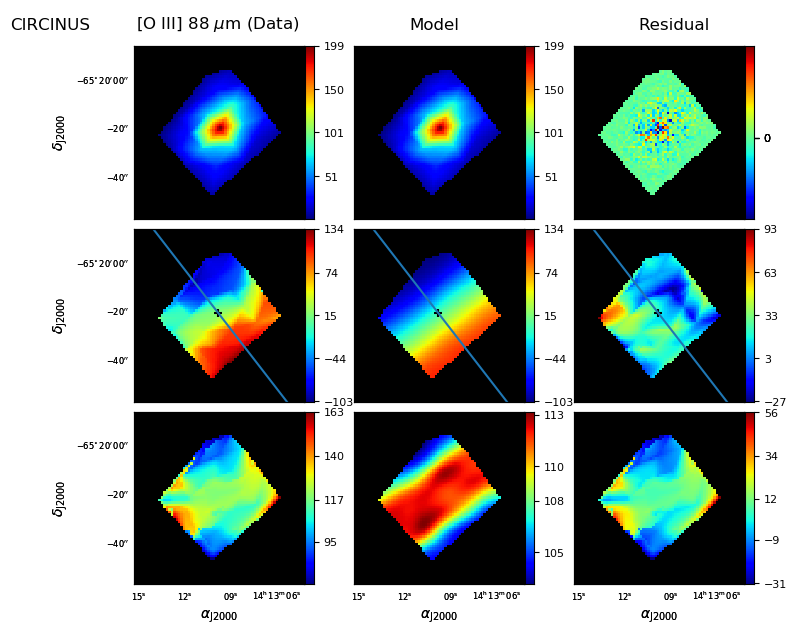

In [10]:
    # Moments of both data and barolo model.
    saveFile = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                +arcsec+'/3dBarolo/'+lineName+'/'+out+'/'+lineName
                +'_cmapMom.pdf')

    makeColormaps(images=imageListMom,
                  wcs=pacsWcs,
                  majX=x,
                  majY=y,
                  xCen=xcen,
                  yCen=ycen,
                  objectName=obsInfo.objectName,
                  lineLabel=lineDict[lineName]['texLabel'],
                  saveFile=saveFile,
                  mask = newMask,
                  savePlot=False)

In [20]:
    if arcsec != '1arc':
        saveFile = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                    +arcsec+'/3dBarolo/'+lineName+'/'+out+'/'+lineName+'_contSub.pdf')

        plotLineProfiles(dataCube = dataMasked,
                         dataModCube = dataModMasked,
                         modelCube = barModelFluxes,
                         vels = vels,
                         validPixels = validPixels,
                         saveFile = saveFile,
                         savePlot = True)

In [32]:
import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import PercentileInterval
from astropy.visualization import LinearStretch, PowerStretch 

dataMaj = fits.open(topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                          +arcsec+'/3dBarolo/'+lineName+'/'+out+'/pvs/'
                          +obsInfo.objectName+'_pv_a.fits')[0].data

inc,pa,vsys,vrad = np.genfromtxt(topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                          +arcsec+'/3dBarolo/'+lineName+'/'+out+'/ringlog1.txt',skip_header=1,usecols=(3,4,10,11),unpack=True) 

vsys = np.nanmean(vsys)
pa = np.nanmean(pa)

cont = 0.00245171
v = np.array([1,2,4,8,16,32,64])*cont 
v_neg = [-cont] 
interval = PercentileInterval(99.5) 
vmax = interval.get_limits(dataMaj)[1] 
norm = ImageNormalize(vmin=cont, vmax=vmax, stretch=PowerStretch(0.5)) 

In [39]:
    image_mod_maj     = fits.open(topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                         +arcsec+'/3dBarolo/'+lineName+'/modelOut0/pvs/'
                         +obsInfo.objectName+'mod_pv_a_local.fits')
    head = image_mod_maj[0].header
    crpixpv = np.array([head['CRPIX1']])
    cdeltpv = np.array([head['CDELT1']])
    crvalpv = np.array([head['CRVAL1']])
    xminpv, xmaxpv = np.floor(crpixpv-1-12), np.ceil(crpixpv-1 +12) 
    if xminpv<0: xminpv=0 
    if xmaxpv>=head['NAXIS1']: 
        xmaxpv=head['NAXIS1']-1
    zmin, zmax = 67, 303
    data_mod_maj = image_mod_maj[0].data[zmin:zmax+1,int(xminpv):int(xmaxpv)+1]

    xmin_wcs = ((xminpv+1-crpixpv)*cdeltpv+crvalpv)*3600
    xmax_wcs = ((xmaxpv+1-crpixpv)*cdeltpv+crvalpv)*3600
    zmin_wcs, zmax_wcs = -206.819, 1074.31
    vsysmean, pamean = np.nanmean(vsys), np.nanmean(pa) 
    ext = [xmin_wcs, xmax_wcs, zmin_wcs-vsysmean, zmax_wcs-vsysmean]

In [24]:
import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import PercentileInterval
from astropy.visualization import LinearStretch, PowerStretch 

xmin, xmax = 0, 23
ymin, ymax = 0, 23
zmin, zmax = 59, 311

image = fits.open('/Volumes/QbertPrimary/umdResearch/adapProposalNearby/pySpecKitCube/run4/circinus/1arc/3dBarolo/inFits/1342191297_circinus_oiii88_hdrEditVel.fits') 
data = image[0].data[zmin:zmax+1,ymin:ymax+1,xmin:xmax+1]

outfolder = topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'+arcsec+'/3dBarolo/'+lineName+'/out1/'

twostage=True 
plotmask=False 
rad,vrot,disp,inc,pa,z0,xpos,ypos,vsys,vrad = np.genfromtxt(outfolder+'ringlog1.txt',skip_header=1,usecols=(1,2,3,4,5,7,9,10,11,12),unpack=True) 
err1_l, err1_h = np.zeros(shape=(10,len(rad))), np.zeros(shape=(10,len(rad)))
color=color2='#B22222' 
max_vrot,max_vdisp,max_inc,max_pa=np.max(vrot),np.max(disp),np.max(inc),np.max(pa) 
max_z0,max_xpos,max_ypos,max_vsys=np.max(z0),np.max(xpos),np.max(ypos),np.max(vsys) 
max_rad = 1.1*np.max(rad) 
twostage = True
if twostage: 
    rad2, vrot2,disp2,inc2,pa2,z02,xpos2,ypos2,vsys2, vrad2 = np.genfromtxt(outfolder+'ringlog2.txt',skip_header=1,usecols=(1,2,3,4,5,7,9,10,11,12),unpack=True)
    err2_l, err2_h = np.zeros(shape=(10,len(rad2))), np.zeros(shape=(10,len(rad2)))
    color='#A0A0A0' 
    max_vrot,max_vdisp,max_inc,max_pa=np.maximum(max_vrot,np.max(vrot2)),np.maximum(max_vdisp,np.max(disp2)),np.maximum(max_inc,np.max(inc2)),np.maximum(max_pa,np.max(pa2)) 
    max_z0,max_xpos,max_ypos,max_vsys=np.maximum(max_z0,np.max(z02)),np.maximum(max_xpos,np.max(xpos2)),np.maximum(max_ypos,np.max(ypos2)),np.maximum(max_vsys,np.max(vsys2)) 

cont = 0.00245171
v = np.array([1,2,4,8,16,32,64])*cont 
v_neg = [-cont] 
interval = PercentileInterval(99.5) 
vmax = interval.get_limits(data)[1] 
norm = ImageNormalize(vmin=cont, vmax=vmax, stretch=PowerStretch(0.5)) 

invalid value encountered in power
invalid value encountered in less


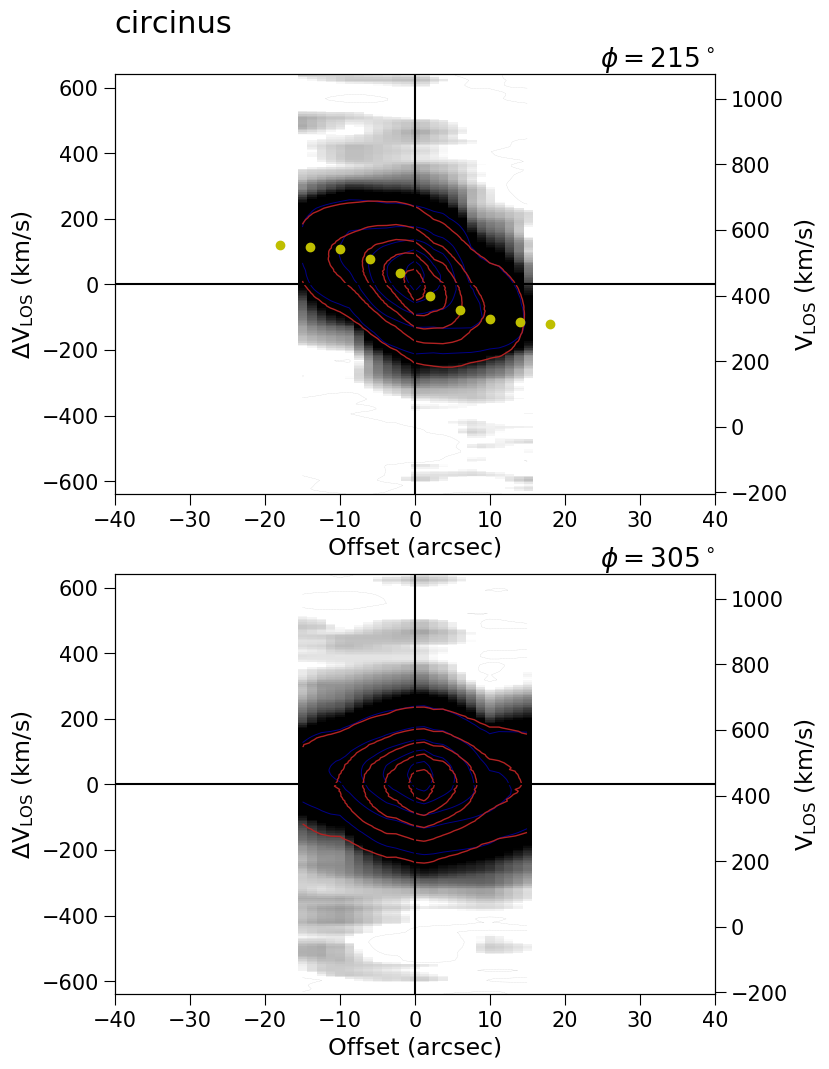

In [25]:
image_maj     = fits.open(outfolder+'pvs/'+obsInfo.objectName+'_pv_a.fits') 
image_min     = fits.open(outfolder+'pvs/'+obsInfo.objectName+'_pv_b.fits') 
image_mas_maj = fits.open(outfolder+'pvs/'+obsInfo.objectName+'mask_pv_a.fits') 
image_mas_min = fits.open(outfolder+'pvs/'+obsInfo.objectName+'mask_pv_b.fits') 
head = [image_maj[0].header,image_min[0].header] 
crpixpv = np.array([head[0]['CRPIX1'],head[1]['CRPIX1']]) 
cdeltpv = np.array([head[0]['CDELT1'],head[1]['CDELT1']]) 
crvalpv = np.array([head[0]['CRVAL1'],head[1]['CRVAL1']]) 
xminpv, xmaxpv = np.floor(crpixpv-1-12), np.ceil(crpixpv-1 +12) 
if xminpv[0]<0: xminpv[0]=0 
if xminpv[1]<0: xminpv[1]=0 
if xmaxpv[0]>=head[0]['NAXIS1']: xmaxpv[0]=head[0]['NAXIS1']-1 
if xmaxpv[1]>=head[1]['NAXIS1']: xmaxpv[1]=head[1]['NAXIS1']-1 
data_maj = image_maj[0].data[zmin:zmax+1,int(xminpv[0]):int(xmaxpv[0])+1] 
data_min = image_min[0].data[zmin:zmax+1,int(xminpv[1]):int(xmaxpv[1])+1] 
data_mas_maj = image_mas_maj[0].data[zmin:zmax+1,int(xminpv[0]):int(xmaxpv[0])+1] 
data_mas_min = image_mas_min[0].data[zmin:zmax+1,int(xminpv[1]):int(xmaxpv[1])+1] 
xmin_wcs = ((xminpv+1-crpixpv)*cdeltpv+crvalpv)*3600
xmax_wcs = ((xmaxpv+1-crpixpv)*cdeltpv+crvalpv)*3600
zmin_wcs, zmax_wcs = -206.819, 1074.31

radius = np.concatenate((rad,-rad)) 
vrotation, inclin, vsystem, posang = vrot, inc, vsys, pa  

if twostage==True:
 	radius, vrotation, inclin, vsystem, posang = np.concatenate((rad2,-rad2)), vrot2, inc2, vsys2, pa2 
vlos1 = vrotation*np.sin(np.deg2rad(inclin))+vsystem 
vlos2 = vsystem-vrotation*np.sin(np.deg2rad(inclin)) 

reverse = True 
if reverse==True: vlos1, vlos2 = vlos2, vlos1 
vlos = np.concatenate((vlos1,vlos2)) 



vsysmean, pamean = np.nanmean(vsystem), np.nanmean(posang) 
ext = [[xmin_wcs[0],xmax_wcs[0],zmin_wcs-vsysmean,zmax_wcs-vsysmean],\
       [xmin_wcs[1],xmax_wcs[1],zmin_wcs-vsysmean,zmax_wcs-vsysmean]] 
labsize = 15 
palab = ['$\phi = $215$^\circ$', '$\phi = $305$^\circ$'] 

# Beginning PV plot 
#for k in range (2): 

image_mod_maj = fits.open(outfolder+'pvs/'+obsInfo.objectName+'mod_pv_a_local.fits') 
image_mod_min = fits.open(outfolder+'pvs/'+obsInfo.objectName+'mod_pv_b_local.fits')
data_mod_maj = image_mod_maj[0].data[zmin:zmax+1,int(xminpv[0]):int(xmaxpv[0])+1] 
data_mod_min = image_mod_min[0].data[zmin:zmax+1,int(xminpv[1]):int(xmaxpv[1])+1] 
toplot = [[data_maj,data_min],[data_mod_maj,data_mod_min],[data_mas_maj,data_mas_min]] 


levels = np.array([.1,.3,.5,.7,.9])*np.nanmax(toplot[0][0])

fig=plt.figure(dpi=100, facecolor='white',figsize=(10,7)) 
fig_ratio = 10/7.
x_len, y_len, y_sep = 0.6, 0.42, 0.08 
ax, bottom_corner = [], [0.1,0.7] 
for i in range (2): 
    bottom_corner[0], axcol = 0.1, [] 
    ax.append(fig.add_axes([bottom_corner[0],bottom_corner[1],x_len,y_len*fig_ratio])) 
    bottom_corner[1]-=(y_len+y_sep)*fig_ratio 

#for i in range (2):
    levels0 = np.array([.1,.3,.5,.7,.9])*np.nanmax(toplot[0][i])
    levels1 = np.array([.1,.3,.5,.7,.9])*np.nanmax(toplot[1][i])

    axis = ax[i] 
    axis.tick_params(which='major',length=8, labelsize=labsize) 
    axis.set_xlabel('Offset (arcsec)',fontsize=labsize+2) 
    axis.set_ylabel('$\mathrm{\Delta V_{LOS}}$ (km/s)',fontsize=labsize+2) 
    axis.text(1, 1.02,palab[i],ha='right',transform=axis.transAxes,fontsize=labsize+4) 
    axis2 = axis.twinx() 
    axis2.set_xlim(-40,40) 
    axis2.set_ylim([ext[i][2]+vsysmean,ext[i][3]+vsysmean]) 
    axis2.tick_params(which='major',length=8, labelsize=labsize) 
    axis2.set_ylabel('$\mathrm{V_{LOS}}$ (km/s)',fontsize=labsize+2) 
    axis.imshow(toplot[0][i],origin='lower',cmap = matplotlib.cm.Greys,norm=norm,extent=ext[i],aspect='auto') 
    axis.contour(toplot[0][i],levels0, origin='lower',norm=norm,
                 extent=ext[i],colors='#00008B',linewidths=0.7)
    axis.contour(toplot[0][i],v_neg,origin='lower',linewidths=0.1,colors='gray',extent=ext[i]) 
    axis.contour(toplot[1][i],levels1,origin='lower',linewidths=1,colors='#B22222',extent=ext[i]) 
    axis.axhline(y=0,color='black') 
    axis.axvline(x=0,color='black')  
    if i==0 : 
        axis2.plot(radius,vlos,'yo') 
        axis.text(0, 1.1, 'circinus', transform=axis.transAxes,fontsize=22)



In [7]:
lines = ['oiii88', 'oi63', 'cii158', 'oi145', 'nii122']
outs = ['modOut0', 'modOut0', 'modOut0', 'modOut0', 'modOut0']


vsysList = np.array([])
for ii in range(len(lines)):
    try:
        ringLogFile = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                       +arcsec+'/3dBarolo/'+lines[ii]+'/'+outs[ii]+'/ringlog2.txt')
        rad,vrot,disp,inc,pa,z0,xpos,ypos,vsys,vrad = np.genfromtxt(ringLogFile,skip_header=1,
                                                                    usecols=(1,2,3,4,5,7,9,10,11,12),
                                                                    unpack=True) 

    except:
        ringLogFile = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                       +arcsec+'/3dBarolo/'+lines[ii]+'/'+outs[ii]+'/ringlog1.txt')
        rad,vrot,disp,inc,pa,z0,xpos,ypos,vsys,vrad = np.genfromtxt(ringLogFile,skip_header=1,
                                                                    usecols=(1,2,3,4,5,7,9,10,11,12),
                                                                    unpack=True)
    vsysList = np.append(vsys,vsysList)






linesDict = {}
for ii in range(len(lines)):
    try:
        ringLogFile = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                       +arcsec+'/3dBarolo/'+lines[ii]+'/'+outs[ii]+'/ringlog2.txt')
        rad,vrot,disp,inc,pa,z0,xpos,ypos,vsys,vrad = np.genfromtxt(ringLogFile,skip_header=1,
                                                                    usecols=(1,2,3,4,5,7,9,10,11,12),
                                                                    unpack=True) 

    except:
        ringLogFile = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                       +arcsec+'/3dBarolo/'+lines[ii]+'/'+outs[ii]+'/ringlog1.txt')
        rad,vrot,disp,inc,pa,z0,xpos,ypos,vsys,vrad = np.genfromtxt(ringLogFile,skip_header=1,
                                                                    usecols=(1,2,3,4,5,7,9,10,11,12),
                                                                    unpack=True) 

    xmin,ymin = 0,0
    xmax,ymax = barIntFluxes.shape

    xcen, ycen, phi = [np.nanmean(xpos)-xmin,np.nanmean(ypos)-ymin,np.nanmean(pa)]

    # Coordinates of the major axis.
    x = np.arange(0,xmax-xmin,0.1) 
    y = np.tan(np.radians(phi-90))*(x-xcen)+ycen 

    
    vsys = np.nanmean(np.nanmean(vsysList))
    pa = np.nanmean(pa)

    radius = np.concatenate((rad,-rad)) 
    vrotation, inclin, vsystem, posang = vrot, inc, vsys, pa  

    vlos1 = vrotation*np.sin(np.deg2rad(inclin))+vsystem 
    vlos2 = vsystem-vrotation*np.sin(np.deg2rad(inclin)) 

    reverse = True 
    if reverse==True: vlos1, vlos2 = vlos2, vlos1 
    vlos = np.concatenate((vlos1,vlos2)) 

    linesDict.setdefault(lines[ii],dict())
    linesDict[lines[ii]].setdefault('radius',radius)
    linesDict[lines[ii]].setdefault('vlos',vlos)
    linesDict[lines[ii]].setdefault('label',lines[ii])

In [8]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

save = True
saveFile =  (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                +arcsec+'/3dBarolo/scatter.pdf')


fig = plt.figure(facecolor='white',dpi=75,figsize=(8,5))
for key in linesDict.keys():
    ax = fig.add_subplot(111,xlim=[-40,40],ylim=[-150,150])
    ax.scatter(linesDict[key]['radius'],linesDict[key]['vlos']-vsys,label=linesDict[key]['label'])
    ax.legend()
    ax.axvline(0,color='grey',alpha=.8)
    ax.axhline(0,color='grey',alpha=.8)
    ax.set_title(obsInfo.objectName.upper() + '     (vsys = '+str(int(vsys))+')')
if save == True:
    pp = PdfPages(saveFile)
    pp.savefig(fig, bbox_inches='tight')
    pp.close()
    plt.close()
else:
    plt.show()


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [16]:
import matplotlib.pyplot as plt

maskFits = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                       +arcsec+'/3dBarolo/'+lineName+'/'+out+'/mask.fits')
barMaskHdu = fits.open(maskFits)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.imshow(barMask)
# plt.show()

In [17]:
barMaskHdu.info()

Filename: /Volumes/QbertPrimary/umdResearch/adapProposalNearby/pySpecKitCube/run4/circinus/1arc/3dBarolo/oiii88/modOut2/mask.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   (70, 71, 370)   int16   


In [28]:
hdr = barMaskHdu[0].header
start = hdr['CRVAL3']
stop = hdr['NAXIS3']
step = hdr['CDELT3']

velArr = np.arange(start,start+(step*stop),step)

In [29]:
barMaskHdu[0].data[:,34,30].shape, len(velArr),start,stop,step

((370,), 370, -570.53009445, 370, 5.4206713669)

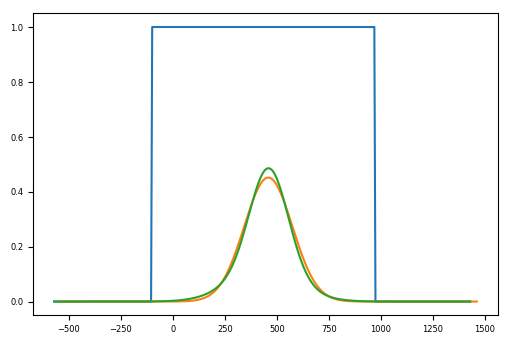

In [44]:
flux = barMaskHdu[0].data[:,34,30]

fig = plt.figure(facecolor='white',dpi=100)
ax = fig.add_subplot(111)
ax.plot(velArr,flux)
ax.plot(velArr+32,barModelFluxes[:,34,30])
ax.plot(velArr,dataModMasked[:,34,30])
plt.show()

In [45]:
def log_transform(im):
    '''returns log(image) scaled to the interval [0,1]'''
    try:
        (min, max) = (im[im > 0].min(), im.max())
        if (max > min) and (max > 0):
            return (np.log(im.clip(min, max)) - np.log(min)) / (np.log(max) - np.log(min))
    except:
        pass
    return im

Rasterization of '<matplotlib.collections.QuadMesh object at 0x1c24326b50>' will be ignored
Rasterization of '<matplotlib.collections.QuadMesh object at 0x1c23b56e10>' will be ignored
Rasterization of '<matplotlib.collections.QuadMesh object at 0x1c2411b650>' will be ignored


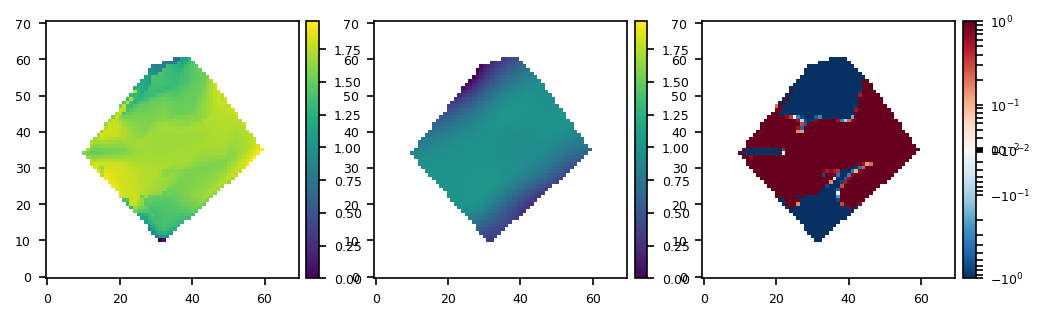

In [69]:
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib


mom2Log = np.log10(mom2 + 1 - np.nanmin(mom2))
mom2ModLog = np.log10(mom2Mod + 1 - np.nanmin(mom2Mod))
mom2ResLog = np.log10(((mom2-mom2Mod)) + 1 - np.nanmin((mom2-mom2Mod)))

vMin = np.nanmin(np.concatenate((mom2Log,mom2ModLog,mom2ResLog)))
vMax = np.nanmax(np.concatenate((mom2Log,mom2ModLog,mom2ResLog)))

fig = plt.figure(facecolor='white',dpi=150,figsize=(8,6))
ax = fig.add_subplot(131)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(mom2Log,vmin=vMin,vmax=vMax)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.invert_yaxis()


ax1 = fig.add_subplot(132)
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
im1 = ax1.imshow(mom2ModLog,vmin=vMin,vmax=vMax)
fig.colorbar(im1, cax=cax1, orientation='vertical')
ax1.invert_yaxis()

ax2 = fig.add_subplot(133)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
im2 = ax2.imshow(mom2-mom2Mod,
                 norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                        vmin=-1.0, vmax=1.0),
                 cmap = 'RdBu_r')

fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.invert_yaxis()

plt.show()

In [72]:
modFits = (topDir+'pySpecKitCube/run4/'+obsInfo.objectName+'/'
                       +arcsec+'/3dBarolo/'+lineName+'/'+out+
           '/'+obsInfo.objectName+'mod_local.fits')
mHdu = fits.open(modFits)

In [73]:
mHdu.info()

Filename: /Volumes/QbertPrimary/umdResearch/adapProposalNearby/pySpecKitCube/run4/circinus/1arc/3dBarolo/oiii88/modOut2/circinusmod_local.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   (70, 71, 370)   float32   
